# ==== INTERACTIVE CLUSTERING : BUSINESS RELEVANCE STUDY ====
> ### Stage 1 : Evaluate business relevance on previous experiments.

------------------------------
## READ-ME BEFORE RUNNING

### Quick Description

This notebook is **aimed at compute business relevance on interactive clustering experiments**.
- Computations are based on previous experiments (cf. efficience study) exported in `./previous` folder.
- Environments results are stored in their `.JSON` files in the `/experiments` folder.

Then, **go to the notebook `2_Plot_some_figures.ipynb` to plot several figures according to these computations**.

### Description each steps

The several computations are :
- `consistency_score`: Test a TF-IDF + Linear SVM model on its own trainset with a high prediction score threshold in order to check data consistency. The consistency score is the f1-score computed. If f1-score is low (i.e. less than `0.75`), then trainset can be inconsistent : Data may be badly labeled or classes may overlap. Otherwise, f1-score should tend to 100%.
- `fmc_describtion`: Use the Features Maximization Contrast méthod of feature selection in order to describe a cluster by its relevant linguistic patterns.
- `llm_summarization`: Use a large language model (`openai/GPT3.5`) to summarize each cluster as a one sentence description.

Some combinations of parameters are studied:
- `simple_prep` + `tfidf` + `closest-50` + `hier_avg-10c`: best to reach 90% of v-measure (cf. efficiency study)
- `lemma_prep` + `tfidf` + `closest-50` + `kmeans_COP-10c`: best to reach 100% of v-measure (cf. efficiency study)
- `lemma_prep` + `tfidf` + `in_same-50` + `kmeans_COP-10c`: best to reach annotation completeness (cf. efficiency study)
- `simple_prep` + `tfidf` + `closest-50` + `kmeans_COP-10c`: choice of author (cf. cost study)

------------------------------
## 1. IMPORT PYTHON DEPENDENCIES

In [1]:
from typing import Dict, List, Any, Optional
import os
import json

In [2]:
import warnings
warnings.filterwarnings("ignore")

------------------------------
## 2. LOAD EXPERIMENTS TO STUDY

Find all implementations to analyze and associated experiments.

In [3]:
# List of run tasks to parallelize.
LIST_OF_TASKS: List[Dict[str, str]] = [
    {
        "implementation": implementation,  # Environment of experiment.
        "experiments": [
            exp_path
            for exp_path in os.listdir("../previous/"+implementation)
            if ".json" in exp_path
        ]
    }
    for implementation in os.listdir("../previous")
    if (
        os.path.isdir("../previous/" + implementation)
        and implementation in [
            "bank_cards_v1_-_simple_prep_-_tfidf_-_closest-50_-_hier_avg-10c",  # best to reach 90% of v-measure (cf. efficiency study)
            "bank_cards_v1_-_lemma_prep_-_tfidf_-_closest-50_-_kmeans_COP-10c",  # best to reach 100% of v-measure (cf. efficiency study)
            "bank_cards_v1_-_lemma_prep_-_tfidf_-_in_same-50_-_kmeans_COP-10c",  # best to reach annotation completeness (cf. efficiency study)
            "bank_cards_v1_-_simple_prep_-_tfidf_-_closest-50_-_kmeans_COP-10c",  # choice of author (cf. cost study)
            #"bank_cards_v1_-_simple_prep_-_tfidf",  # Mean.
            #"bank_cards_v1",  # Mean.
        ]
    )
]
print("There are", "`" + str(len(LIST_OF_TASKS)) + "`", "implementations to analyze.")

There are `4` implementations to analyze.


Create one folder per implementation to analyze.

In [4]:
for task in LIST_OF_TASKS:
    
    # If folder exists: continue.
    if os.path.isdir("../experiments/" + task["implementation"]):
        continue
    
    # Create folder for analyses.
    os.mkdir("../experiments/" + task["implementation"])
    
    # Copy data.
    for experiment in task["experiments"]:
        with open("../previous/" + task["implementation"] + "/" + experiment, "r") as file_previous_results_r:
            previous_results = json.load(file_previous_results_r)
        with open("../experiments/" + task["implementation"] + "/previous_results___" + experiment, "w") as file_previous_results_w:
            json.dump(
                previous_results,
                file_previous_results_w
            )

------------------------------
## 3. START ANALYSES

----------
### 3.1. Analyze clustering consistency.

Load Python dependencies.

In [5]:
from consistency_score import compute_consistency_score, display_consistency_score

Compute all consistency scores.

In [6]:
# For each implementation.
for task in LIST_OF_TASKS:
    print("IMPLEMENTATION:", task["implementation"])
    
    # For each experiments.
    for experiment in task["experiments"]:
        print("    ", "experiment:", experiment)
    
        # If folder exists: continue.
        if os.path.exists("../experiments/" + task["implementation"] + "/constistency_score___" + experiment):
            continue
        
        # Load data
        with open("../experiments/" + task["implementation"] + "/previous_results___" + experiment, "r") as file_experiment_data_r:
            experiment_data: Dict[str, Any] = json.load(file_experiment_data_r)
        dict_of_preprocessed_texts: Dict[str, str] = experiment_data["dict_of_preprocessed_texts"]
        dict_of_true_intents: Dict[str, str] = experiment_data["dict_of_true_intents"]
        dict_of_clustering_results: Dict[str, Dict[str, str]] = experiment_data["dict_of_clustering_results"]
            
        # Compute consistency score of groundtruth.
        groundtruth_consistency_score: float = compute_consistency_score(
            x_train = [
                dict_of_preprocessed_texts[text_ID]
                for text_ID in dict_of_preprocessed_texts.keys()
            ],
            y_train = [
                dict_of_true_intents[text_ID]
                for text_ID in dict_of_preprocessed_texts.keys()
            ],
            prediction_score_threshold = 0.75,
        )

        # Compute consistency score of clustering.
        clustering_consistency_score_evolution: Dict[str, float] = {
            iteration: compute_consistency_score(
                x_train = [
                    dict_of_preprocessed_texts[text_ID]
                    for text_ID in dict_of_preprocessed_texts.keys()
                ],
                y_train = [
                    str(dict_of_clustering_results[iteration][text_ID])
                    for text_ID in dict_of_preprocessed_texts.keys()
                ],
                prediction_score_threshold = 0.75,
            )
            for iteration in dict_of_clustering_results.keys()
        }
            
        # Store results.
        with open("../experiments/" + task["implementation"] + "/constistency_score___" + experiment, "w") as file_constistency_score_w:
            json.dump(
                {
                    "groundtruth": groundtruth_consistency_score,
                    "evolution": clustering_consistency_score_evolution,
                },
                file_constistency_score_w
            )

IMPLEMENTATION: bank_cards_v1_-_lemma_prep_-_tfidf_-_closest-50_-_kmeans_COP-10c
     experiment: 0001.json
     experiment: 0002.json
     experiment: 0003.json
     experiment: 0004.json
     experiment: 0005.json
IMPLEMENTATION: bank_cards_v1_-_lemma_prep_-_tfidf_-_in_same-50_-_kmeans_COP-10c
     experiment: 0001.json
     experiment: 0002.json
     experiment: 0003.json
     experiment: 0004.json
     experiment: 0005.json
IMPLEMENTATION: bank_cards_v1_-_simple_prep_-_tfidf_-_closest-50_-_hier_avg-10c
     experiment: 0001.json
     experiment: 0002.json
     experiment: 0003.json
     experiment: 0004.json
     experiment: 0005.json
IMPLEMENTATION: bank_cards_v1_-_simple_prep_-_tfidf_-_closest-50_-_kmeans_COP-10c
     experiment: 0001.json
     experiment: 0002.json
     experiment: 0003.json
     experiment: 0004.json
     experiment: 0005.json


Display consistency score evolution in a graph.

In [13]:
config_consistency_score = {
    "bank_cards_v1_-_simple_prep_-_tfidf_-_closest-50_-_hier_avg-10c": {
        "plot_label": "Score de cohérence moyen des tentatives\nayant le meilleur paramétrage moyen pour atteindre\nune annotation partielle (90% de v-measure).",
        "plot_color": "green",
        "graph_filename": "etude-pertinence-consistence-annotation-partielle.png",
    },  # best to reach 90% of v-measure (cf. efficiency study)
    "bank_cards_v1_-_lemma_prep_-_tfidf_-_closest-50_-_kmeans_COP-10c": {
        "plot_label": "Score de cohérence moyen des tentatives\nayant le meilleur paramétrage moyen pour atteindre\nune annotation suffisante (100% de v-measure).",
        "plot_color": "blue",
        "graph_filename": "etude-pertinence-consistence-annotation-suffisante.png",
    },  # best to reach 100% of v-measure (cf. efficiency study)
    "bank_cards_v1_-_lemma_prep_-_tfidf_-_in_same-50_-_kmeans_COP-10c": {
        "plot_label": "Score de cohérence moyen des tentatives\nayant le meilleur paramétrage moyen pour atteindre\nune annotation exhaustive (toutes les contraintes).",
        "plot_color": "red",
        "graph_filename": "etude-pertinence-consistence-annotation-exhaustive.png",
    },  # best to reach annotation completeness (cf. efficiency study)
    "bank_cards_v1_-_simple_prep_-_tfidf_-_closest-50_-_kmeans_COP-10c": {
        "plot_label": "Score de cohérence moyen des tentatives\nayant notre paramétrage favori pour atteindre\n90% de v-measure avec un coût global minimal).",
        "plot_color": "gold",
        "graph_filename": "etude-pertinence-consistence-annotation-retenue.png",
    },  # choice of author (cf. cost study)
}

IMPLEMENTATION: bank_cards_v1_-_lemma_prep_-_tfidf_-_closest-50_-_kmeans_COP-10c 
    ( etude-pertinence-consistence-annotation-suffisante.png )
IMPLEMENTATION: bank_cards_v1_-_lemma_prep_-_tfidf_-_in_same-50_-_kmeans_COP-10c 
    ( etude-pertinence-consistence-annotation-exhaustive.png )
IMPLEMENTATION: bank_cards_v1_-_simple_prep_-_tfidf_-_closest-50_-_hier_avg-10c 
    ( etude-pertinence-consistence-annotation-partielle.png )
IMPLEMENTATION: bank_cards_v1_-_simple_prep_-_tfidf_-_closest-50_-_kmeans_COP-10c 
    ( etude-pertinence-consistence-annotation-retenue.png )


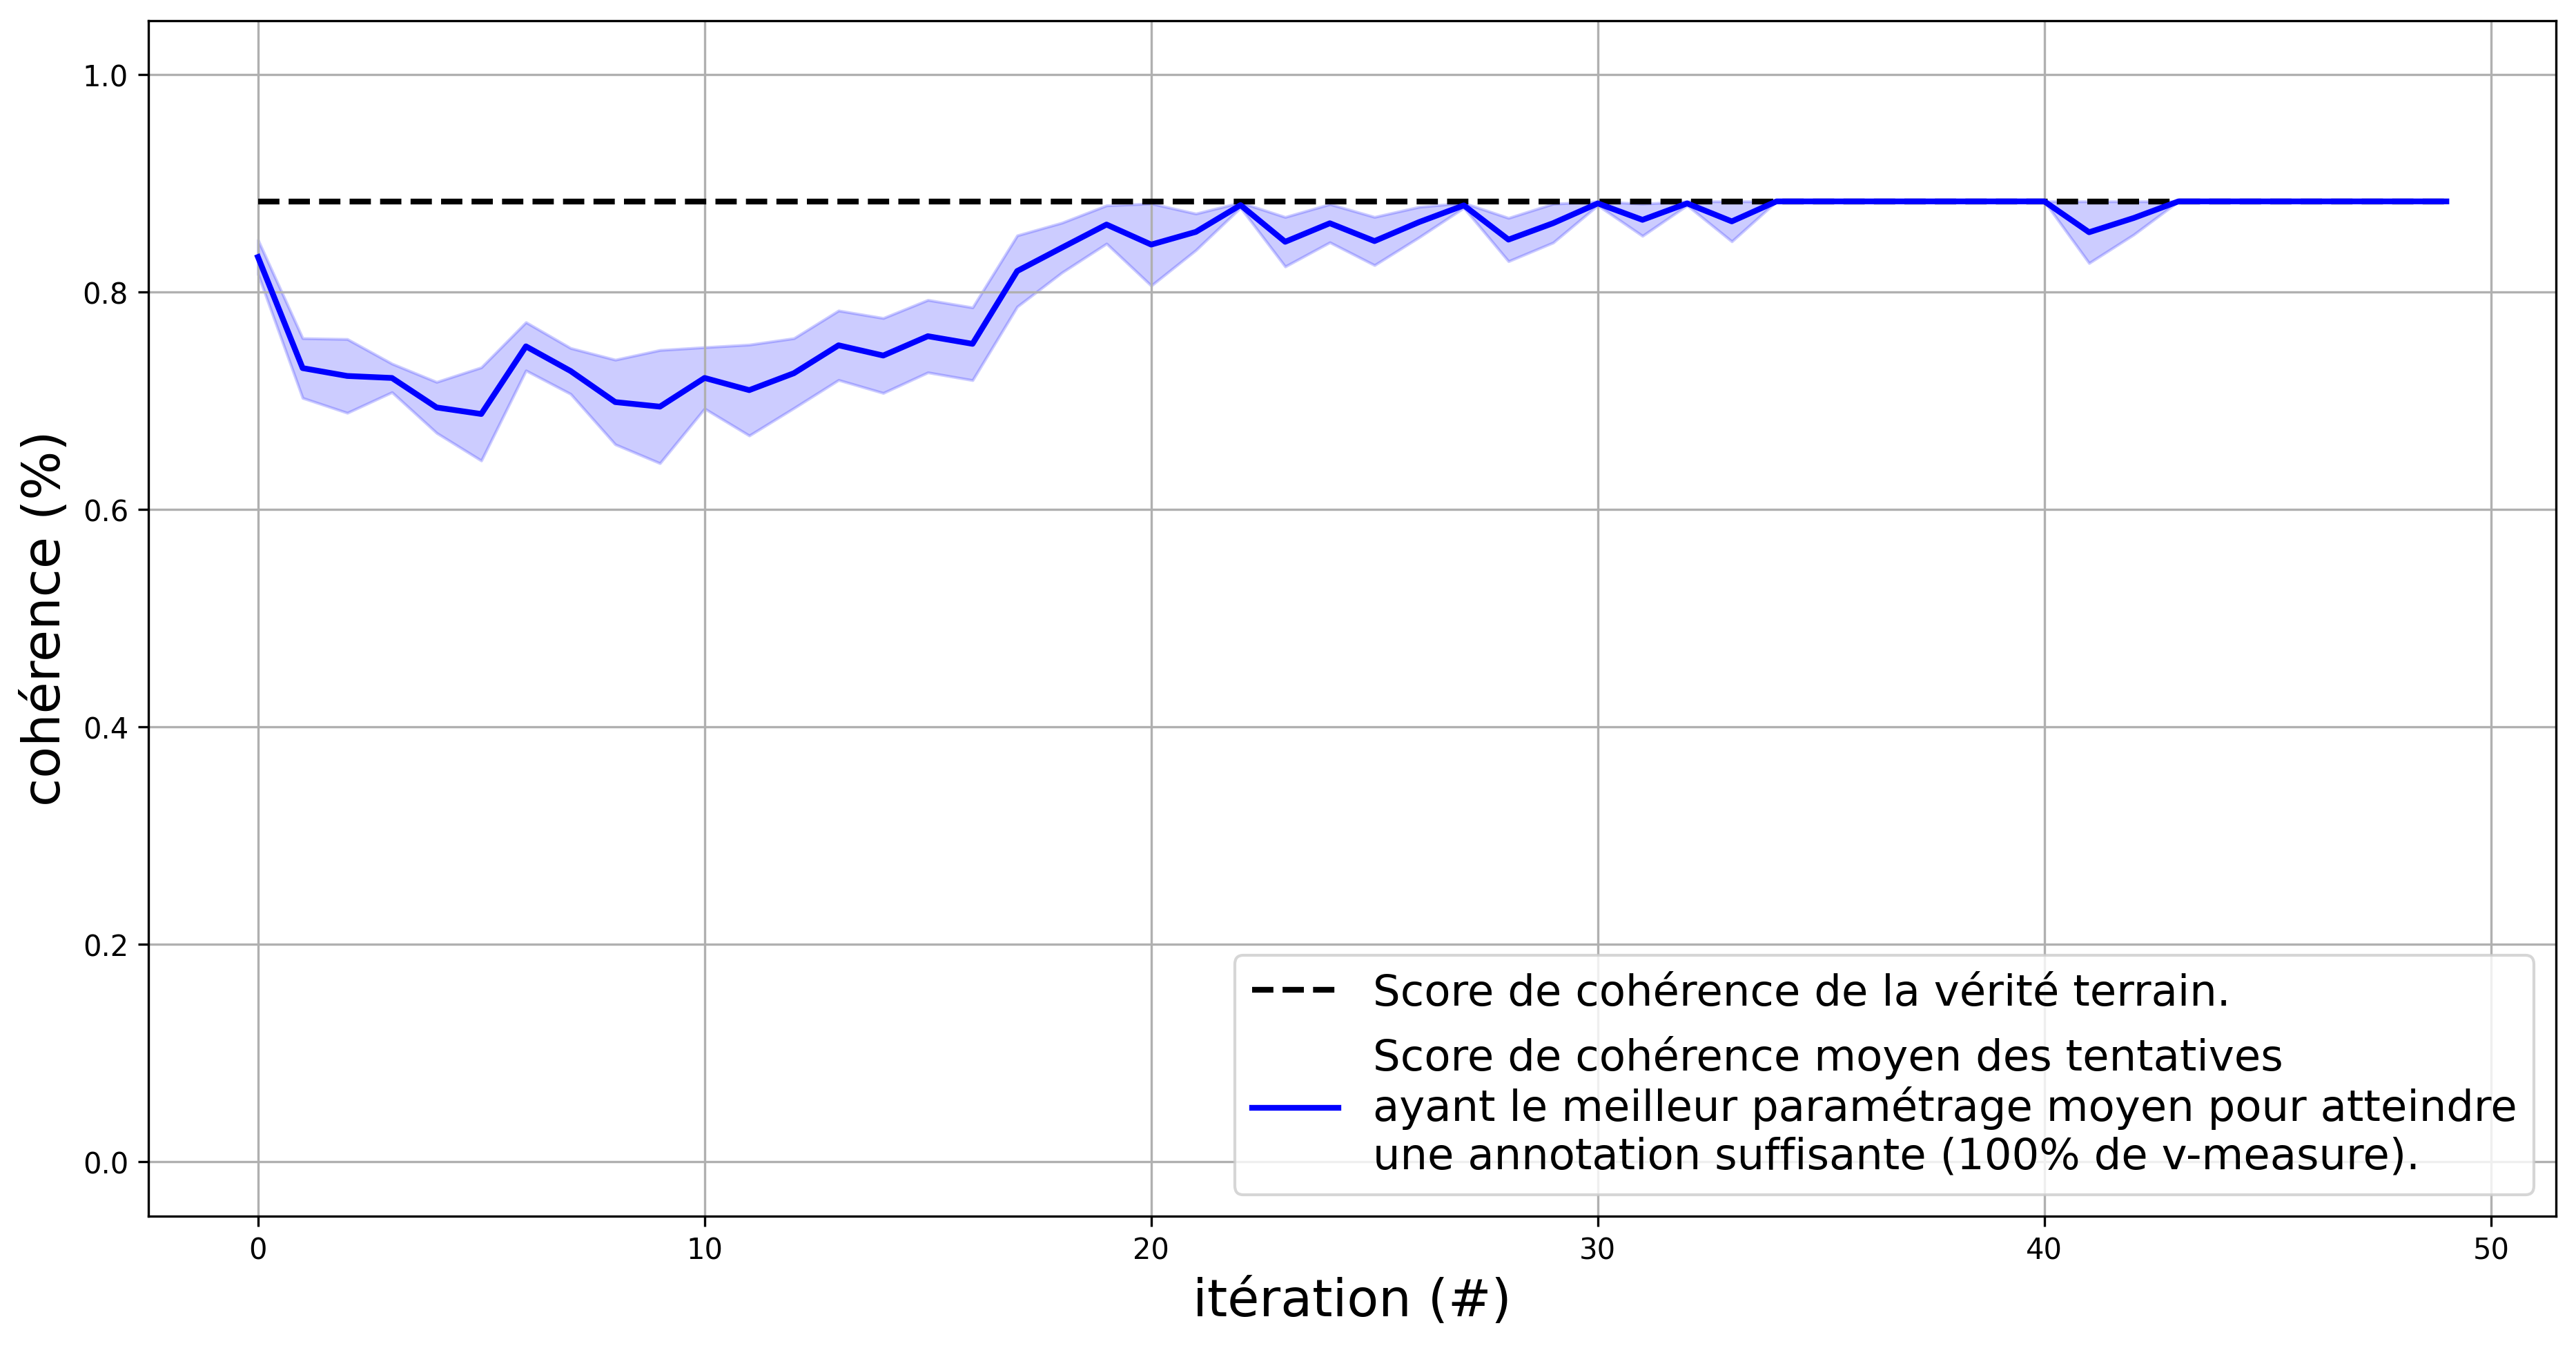

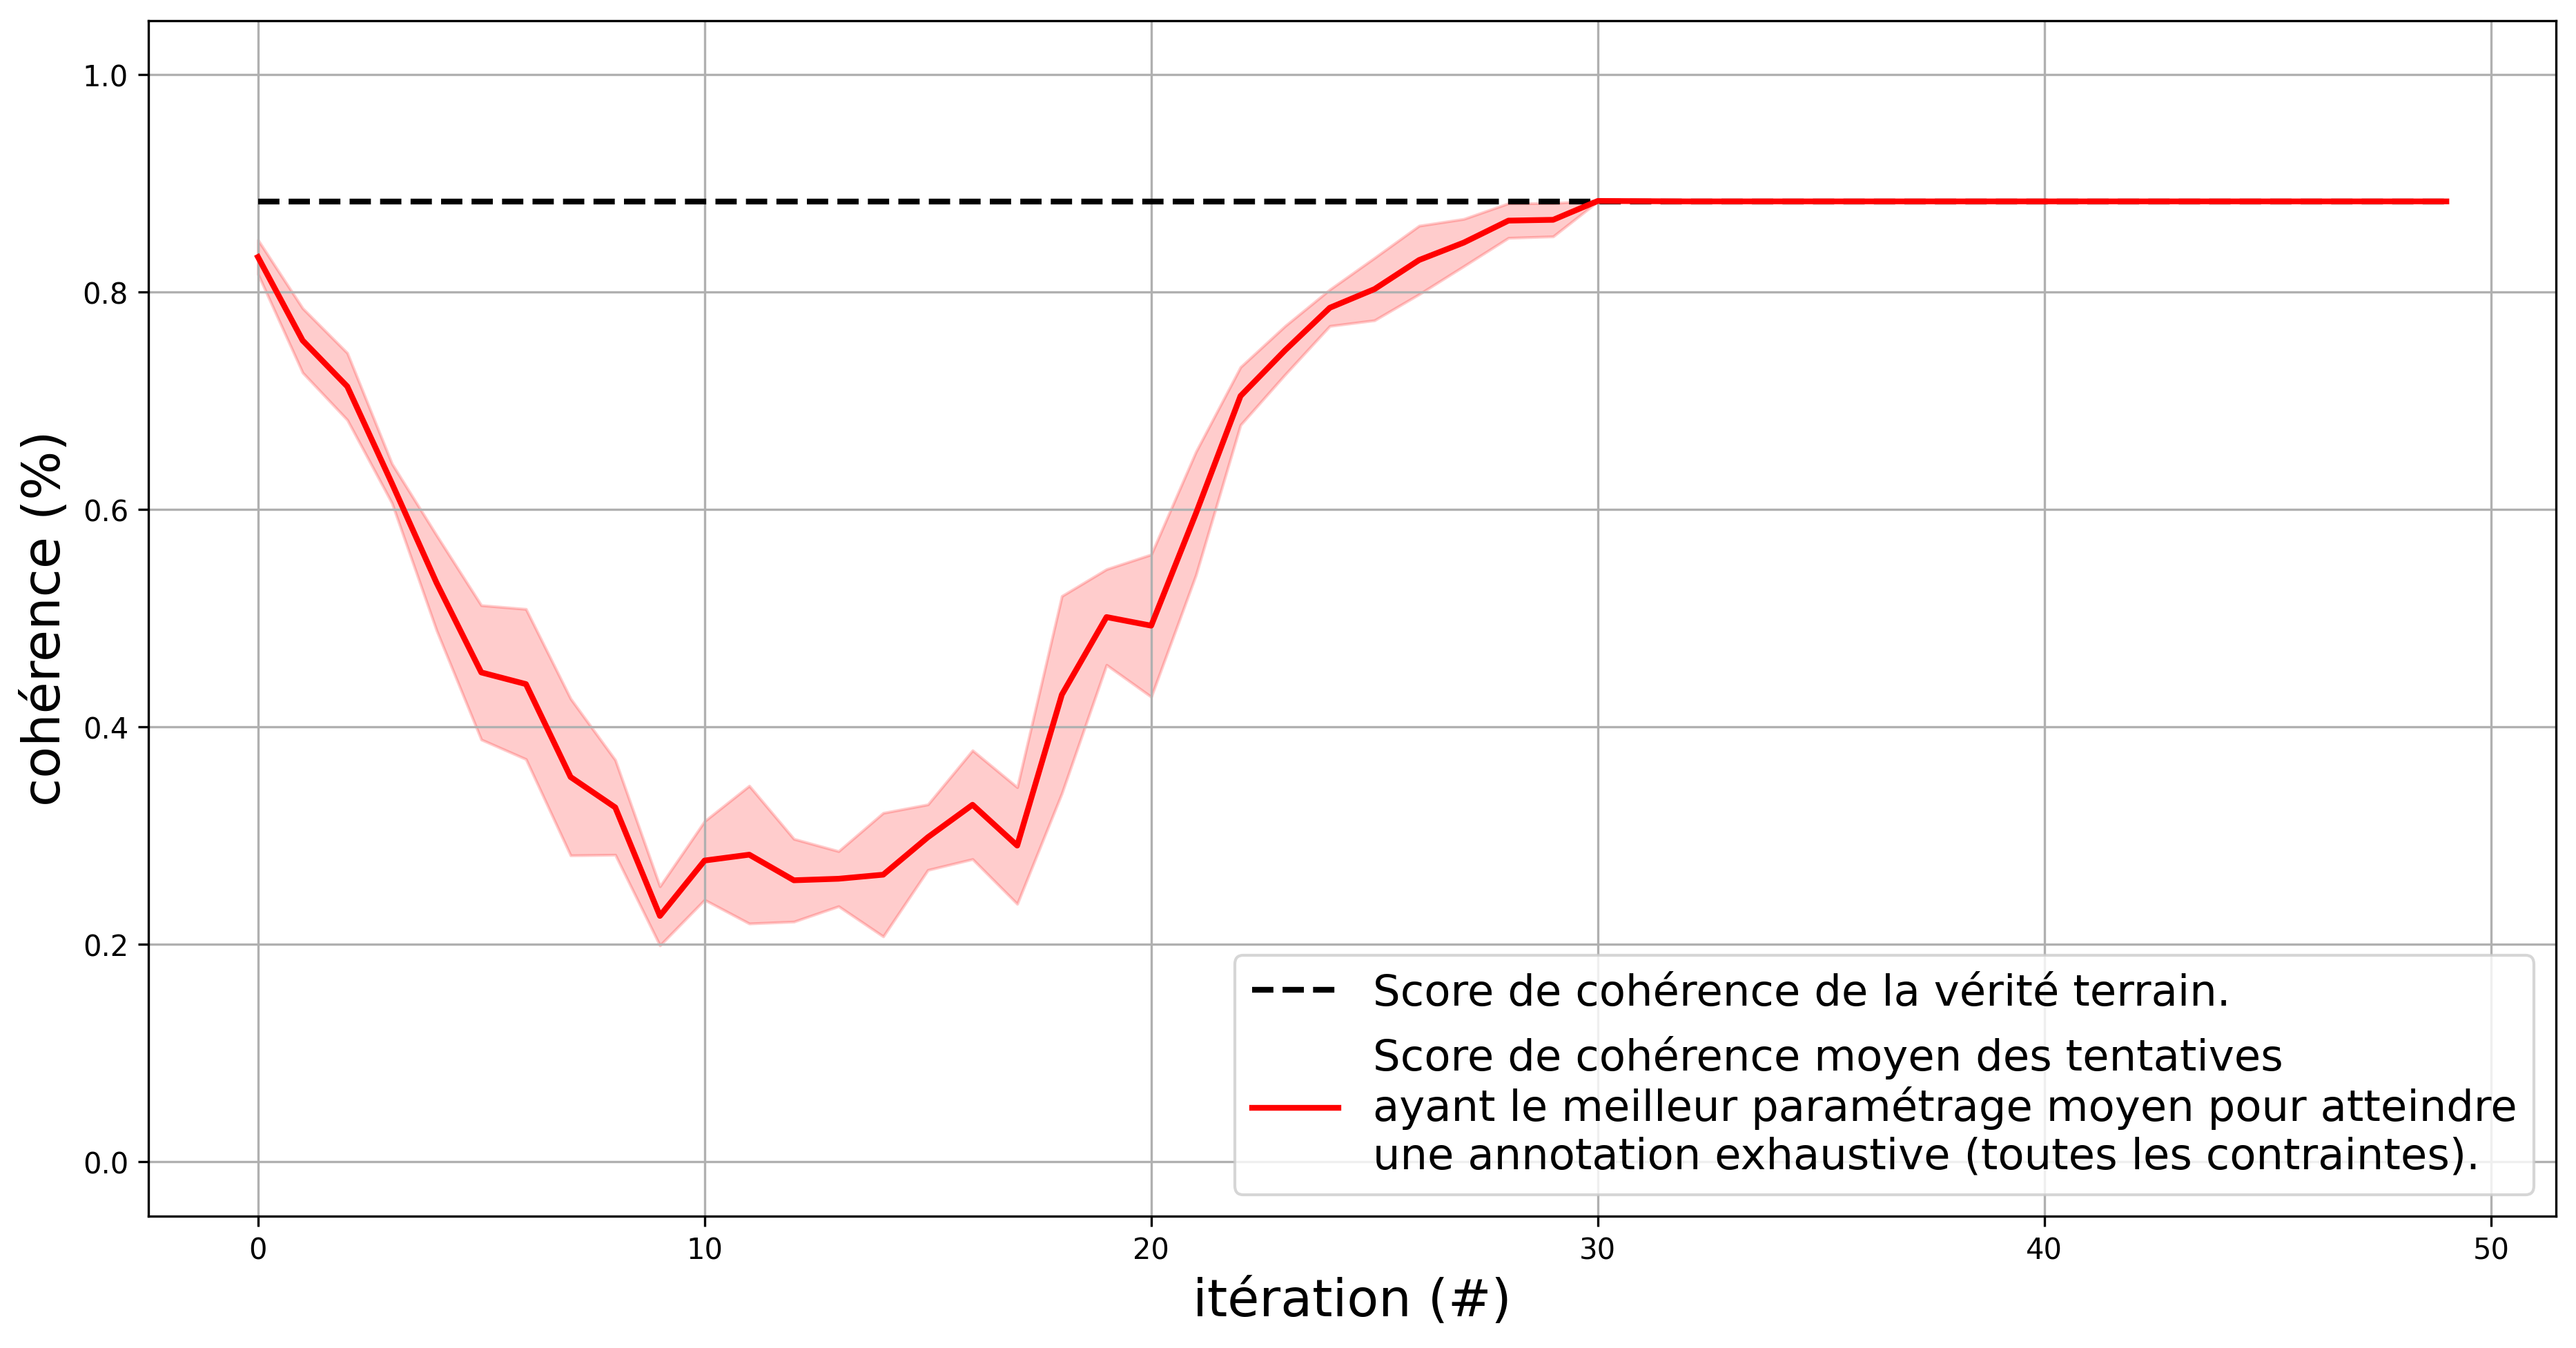

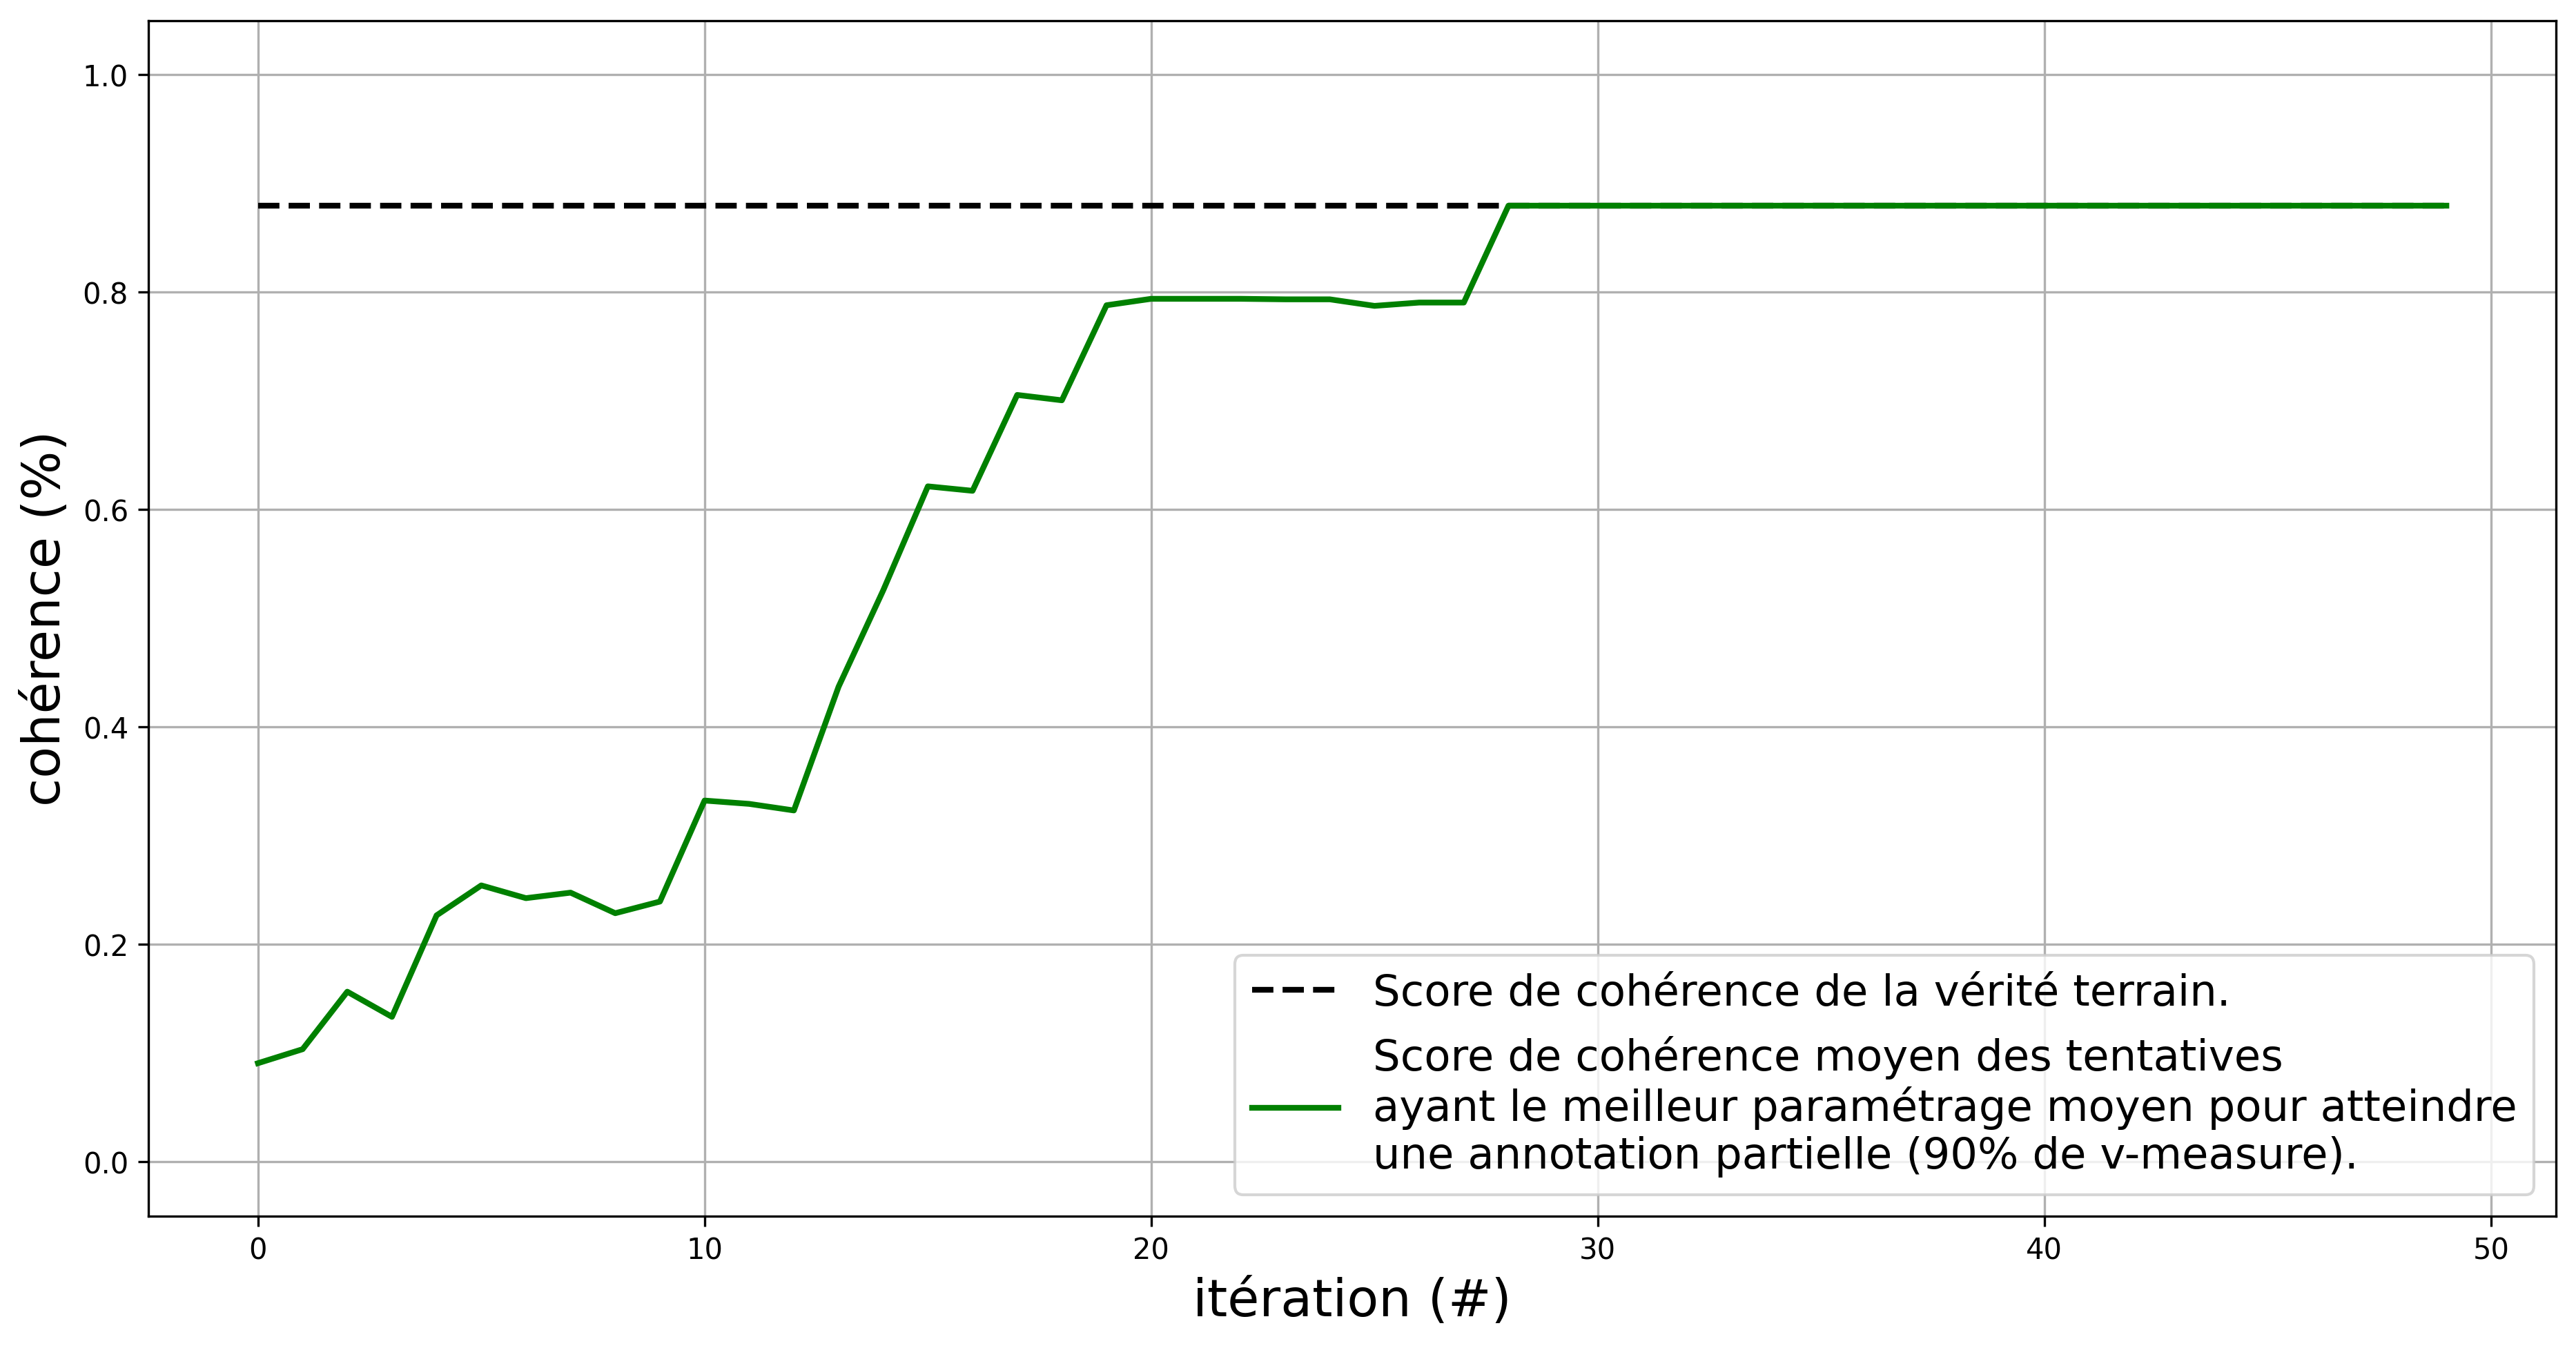

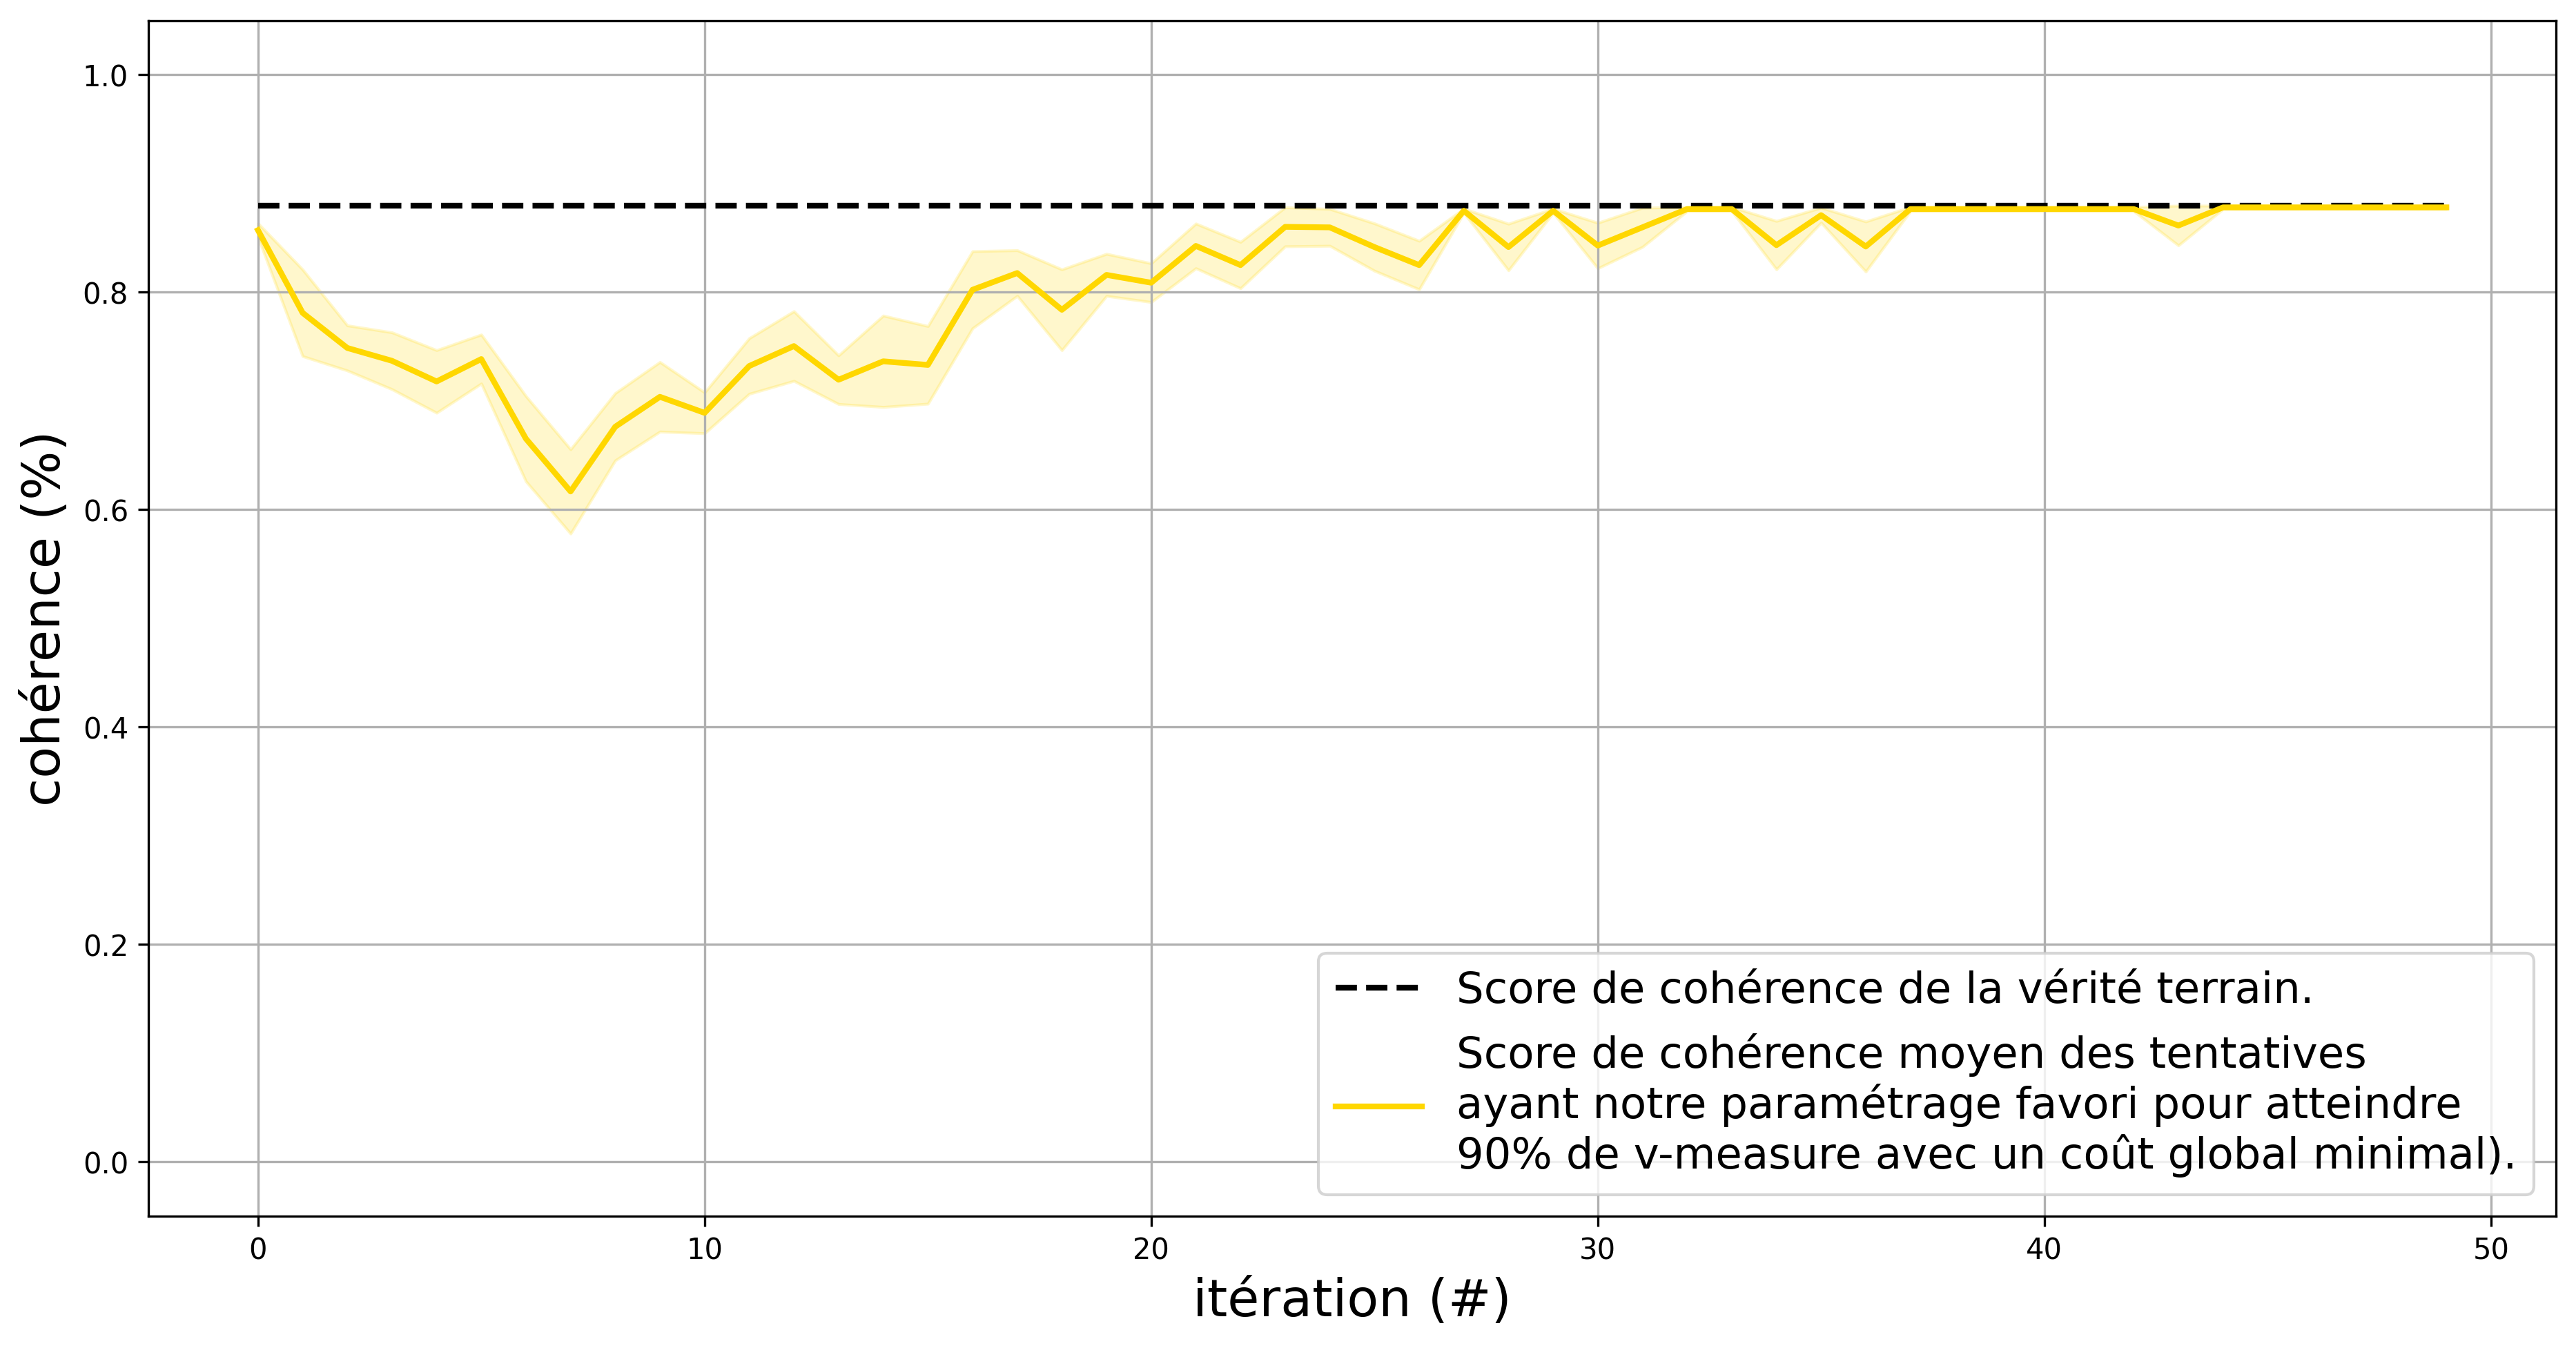

In [15]:
# For each implementation.
for task in LIST_OF_TASKS:
    print("IMPLEMENTATION:", task["implementation"], "\n    (", config_consistency_score[task["implementation"]]["graph_filename"], ")")
    display_consistency_score(
        implementation=task["implementation"],
        list_of_experiments=task["experiments"],
        list_of_iterations=[str(i).zfill(4) for i in range(50)],
        plot_label=config_consistency_score[task["implementation"]]["plot_label"],
        plot_color=config_consistency_score[task["implementation"]]["plot_color"],
        graph_filename=config_consistency_score[task["implementation"]]["graph_filename"],
    )

----------
### 3.2. Describe clusters by their relevant linguistic patterns.

Load Python dependencies.

In [ ]:
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from cognitivefactory.features_maximization_metric.fmc import FeaturesMaximizationMetric

Describe clusters with FMC.

In [ ]:
# For each implementation.
for task in LIST_OF_TASKS:
    print("IMPLEMENTATION:", task["implementation"])
    
    # For each experiments.
    for experiment in task["experiments"]:
        print("    ", "experiment:", experiment)
        
        # Load data.
        with open("../experiments/" + task["implementation"] + "/previous_results___" + experiment, "r") as file_experiment_data_r:
            experiment_data: Dict[str, Any] = json.load(file_experiment_data_r)
        dict_of_preprocessed_texts: Dict[str, str] = experiment_data["dict_of_preprocessed_texts"]
        dict_of_true_intents: Dict[str, str] = experiment_data["dict_of_true_intents"]
        dict_of_clustering_results: Dict[str, Dict[str, str]] = experiment_data["dict_of_clustering_results"]
        
        # Intialize FMC descriptions if need.
        if not os.path.exists("../experiments/" + task["implementation"] + "/fmc_description___" + experiment):
            # Define list of iteration to analyze.
            list_of_iteration: List[str] = [
                i
                for i in dict_of_clustering_results.keys()
                if (
                    int(i) % 5 == 0
                    or i == max(dict_of_clustering_results.keys())
                )
            ]
            # Define initial FMC descriptions for each cluster of each iteration to analyze.
            initial_fmc_descriptions: Dict[str, Dict[str, Optional[List[str]]]] = {
                iteration: {
                    str(cluster_id): None  # need to force cluster_id to str for serialization
                    for cluster_id in sorted(set(dict_of_clustering_results[iteration].values()))
                }
                for iteration in list_of_iteration
            }
            # Store initial FMC descriptions.
            with open("../experiments/" + task["implementation"] + "/fmc_description___" + experiment, "w") as file_initial_fmc_description_w:
                json.dump(initial_fmc_descriptions, file_initial_fmc_description_w)
        
        # Load FMC descriptions already done.
        with open("../experiments/" + task["implementation"] + "/fmc_description___" + experiment, "r") as file_fmc_description_r:
            descriptions: Dict[str, Dict[str, Optional[str]]] = json.load(file_fmc_description_r)
        
        # For each iteration...
        for iteration in descriptions.keys():
            print("    ", "    ", "iteration:", iteration)
            
            # Define vectorizer.
            vectorizer = TfidfVectorizer(min_df=0, ngram_range=(1, 3), analyzer="word", sublinear_tf=True)
            matrix_of_vectors: csr_matrix = vectorizer.fit_transform(
                [
                    str(dict_of_preprocessed_texts[text_id])
                    for text_id in dict_of_preprocessed_texts.keys()
                ]
            )
            list_of_possible_vectors_features: List[str] = list(vectorizer.get_feature_names_out())

            # Define FMC modelization.
            fmc_computer: FeaturesMaximizationMetric = FeaturesMaximizationMetric(
                data_vectors=matrix_of_vectors,
                data_classes=[dict_of_clustering_results[iteration][text_id] for text_id in dict_of_preprocessed_texts.keys()],
                list_of_possible_features=list_of_possible_vectors_features,
                amplification_factor=1,
            )
            
            # For each cluster
            for cluster_id in descriptions[iteration].keys():
                print("    ", "    ", "    ", cluster_id, end=": ")
                
                # If already done: continue
                if descriptions[iteration][str(cluster_id)] is not None:
                    print("(already done)")
                    continue
                
                # Get FMC description of cluster.
                cluster_description: List[str] = [
                    linguistic_pattern
                    for linguistic_pattern in fmc_computer.get_most_active_features_by_a_classe(
                        classe=int(cluster_id),
                        activation_only=True,
                        sort_by='fmeasure',  # "contrast"
                        max_number=50,
                    )
                    if fmc_computer.get_most_activated_classes_by_a_feature(linguistic_pattern) == [int(cluster_id)]
                ]
                print(cluster_description)
                
                # Store updated descriptions.
                descriptions[iteration][str(cluster_id)] = cluster_description
                with open("../experiments/" + task["implementation"] + "/fmc_description___" + experiment, "w") as file_fmc_description_w:
                    json.dump(descriptions, file_fmc_description_w)

----------
### 3.3. Summarize clusters by a large language model.

Load Python dependencies.

In [5]:
import time
import openai

Load credentials.
> Need a file `credentials.py` in projet home (`../..`)
> with content `OPENAI_API_TOKEN = "..."` from https://platform.openai.com/account/api-keys

In [6]:
import sys
sys.path.append("../..")
import credentials  # Need a file `credentials.py` in projet home (`..`) with content `OPENAI_API_TOKEN = "..."` from https://platform.openai.com/account/api-keys
openai.api_key = credentials.OPENAI_API_TOKEN

Define large language model to call and prompt template

In [7]:
# Model to use.
OPENAI_MODEL: str = "gpt-3.5-turbo"

In [8]:
# Prompts to use
prompt_context: str = "Tu es un expert des secteurs banque, assurance et finance."
prompt_task: str = "Résume-moi en une phrase la thématique traitée dans les textes suivants"

Summarize clusters.

In [9]:
MAX_RETRY: int = 5  # retry when timeout.

In [ ]:
# For each implementation.
for task in LIST_OF_TASKS:
    print("IMPLEMENTATION:", task["implementation"])
    
    # For each experiments.
    for experiment in task["experiments"]:
        print("    ", "experiment:", experiment)
        
        # Load data.
        with open("../experiments/" + task["implementation"] + "/previous_results___" + experiment, "r") as file_experiment_data_r:
            experiment_data: Dict[str, Any] = json.load(file_experiment_data_r)
        dict_of_texts: Dict[str, str] = experiment_data["dict_of_texts"]
        dict_of_true_intents: Dict[str, str] = experiment_data["dict_of_true_intents"]
        dict_of_clustering_results: Dict[str, Dict[str, str]] = experiment_data["dict_of_clustering_results"]
        
        # Intialize clustering summaries if need.
        if not os.path.exists("../experiments/" + task["implementation"] + "/llm_summary___" + experiment):
            # Define list of iteration to analyze.
            list_of_iteration: List[str] = [
                i
                for i in dict_of_clustering_results.keys()
                if (
                    int(i) % 5 == 0
                    or i == max(dict_of_clustering_results.keys())
                )
            ]
            # Define initial clustering summaries for each cluster of each iteration to analyze.
            initial_clustering_summaries: Dict[str, Dict[str, Optional[str]]] = {
                iteration: {
                    str(cluster_id): None  # need to force cluster_id to str for serialization
                    for cluster_id in sorted(set(dict_of_clustering_results[iteration].values()))
                }
                for iteration in list_of_iteration
            }
            # Store initial clustering summaries.
            with open("../experiments/" + task["implementation"] + "/llm_summary___" + experiment, "w") as file_initial_llm_summaries_w:
                json.dump(initial_clustering_summaries, file_initial_llm_summaries_w)

        # Load clustering summaries already done.
        with open("../experiments/" + task["implementation"] + "/llm_summary___" + experiment, "r") as file_llm_summary_r:
            summaries: Dict[str, Dict[str, Optional[str]]] = json.load(file_llm_summary_r)
        
        # For each iteration...
        for iteration in summaries.keys():
            print("\n    ", "    ", "iteration:", iteration)
            
            # For each cluster
            for cluster_id in summaries[iteration].keys():
                print("    ", "    ", "    ", cluster_id, end=": ")
                
                # If already done: continue
                if summaries[iteration][str(cluster_id)] is not None:
                    print("(already done)")
                    continue
                
                # Get texts of this cluster.
                cluster = [
                    text
                    for text_id, text in dict_of_texts.items()
                    if dict_of_clustering_results[iteration][text_id] == int(cluster_id)
                ]
                print("(cluster length: {0})".format(len(cluster)), end=" ; ")
                
                # Call the LLM to summarize the document (use loop to by-pass timeout).
                it: int = 0
                last_err: Exception = None
                while it<MAX_RETRY:
                    time.sleep(21)  # To avoid "Rate limit reached" => "default-gpt-3.5-turbo" limited at 3 request per minute.
                    try : 
                        it += 1
                        # Create a chat completion.
                        chat_answers = openai.ChatCompletion.create(
                            model=OPENAI_MODEL,
                            messages=[
                                {
                                    "role": "system",
                                    "content": "{context}".format(
                                        context=prompt_context,
                                    )
                                },
                                {
                                    "role": "user",
                                    "content": "{task} :\n\n{data}".format(
                                        task=prompt_task,
                                        data="- " + "\n- ".join(cluster),
                                    )
                                }
                            ]
                        )
                        break
                    # except OSError :
                    except Exception as err:
                        last_err = err
                        continue
                
                # If error: continue...
                if it==MAX_RETRY:
                    print(last_err)
                    continue
                
                # Get summary from answer.
                cluster_summary: str = chat_answers.choices[0].message.content
                print(cluster_summary[:100], "[...]")
                
                # Store updated summaries.
                summaries[iteration][str(cluster_id)] = cluster_summary
                with open("../experiments/" + task["implementation"] + "/llm_summary___" + experiment, "w") as file_llm_summary_w:
                    json.dump(summaries, file_llm_summary_w)

IMPLEMENTATION: bank_cards_v1_-_lemma_prep_-_tfidf_-_closest-50_-_kmeans_COP-10c
     experiment: 0001.json

          iteration: 0000
               0: (already done)
               1: (already done)
               2: (already done)
               3: (already done)
               4: (already done)
               5: (already done)
               6: (already done)
               7: (already done)
               8: (already done)
               9: (already done)

          iteration: 0005
               0: (already done)
               1: (already done)
               2: (already done)
               3: (already done)
               4: (already done)
               5: (already done)
               6: (already done)
               7: (already done)
               8: (already done)
               9: (already done)

          iteration: 0010
               0: (already done)
               1: (already done)
               2: (already done)
               3: (already done)
               4: (

               7: (cluster length: 53) ; La thématique traitée dans ces textes est la gestion des cartes bancaires (perte, vol, commande, déb [...]
               8: (cluster length: 47) ; La thématique traitée dans les textes est relative aux problèmes rencontrés avec les cartes bancaire [...]
               9: (cluster length: 47) ; Les textes traitent des sujets variés tels que la perte, le vol, la commande, le renouvellement, la  [...]
               10: (cluster length: 13) ; Ces textes traitent des problèmes liés à la récupération de cartes bancaires avalées ou confisquées  [...]

          iteration: 0020
               0: (cluster length: 64) ; Ces textes portent sur deux thématiques distinctes : les garanties d'assurance incluses avec les car [...]
               1: (cluster length: 63) ; Les textes traitent principalement des questions liées aux cartes bancaires, à l'autorisation de déc [...]
               2: (cluster length: 45) ; Les textes traitent de la création, de l'ac